In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader

In [4]:
from einops import rearrange

In [5]:
import matplotlib.pyplot as plt

In [220]:
from copy import deepcopy

In [6]:
import latexify
import math

# Dataset

In [7]:
training_data = datasets.MNIST(root='../data/mnist/train/', train=True, download=True, transform=ToTensor())
testing_data = datasets.MNIST(root='../data/mnist/test/', train=False, download=True, transform=ToTensor())

In [8]:
img, label = training_data[0]

In [9]:
img.shape

torch.Size([1, 28, 28])

In [10]:
label

5

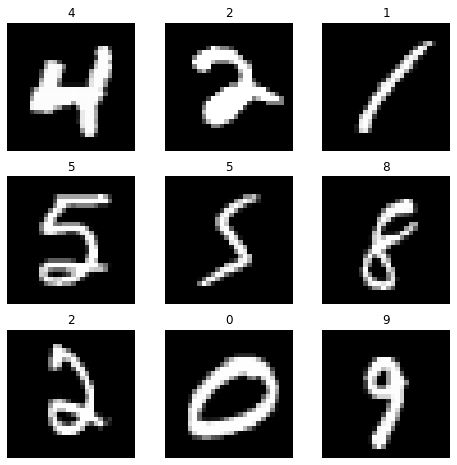

In [11]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [12]:
batch_size = 64

## Dataloader

In [13]:
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle=True)

# Model

In [14]:
class Net(nn.Module):
    
    def __init__(self):
        
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 100)
        self.fc2 = nn.Linear(100, 10)
        
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = nn.MaxPool2d(2, 2)(x)
        x = nn.Dropout(0.1)(x)
        
        x = F.relu(self.conv2(x))
        x = nn.MaxPool2d(2, 2)(x)
        x = nn.Dropout(0.1)(x)
        
        x = rearrange(x, 'b c h d -> b (c h d)')
        
        x = self.fc1(x)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim =-1)

In [15]:
x = torch.rand(1, 1, 28, 28)*200

- Cross enttropy loss in pytorch combines both log_softmax and nll_loss in pytorch, we can either use cross entropy loss and pass it raw logits as input or apply log_softmax on logits and use nll_loss 
- nll_loss is nothing but multiplication with -1. 
- Cross entropy loss is -yi*log(p(yi/x)) and since log_softmax has done most of the work only -1 multiplication is remaining
- softmax is not used as activation directly since it is numerically unstable while log_softmax is stable
- always log_softmax is computed and not softmax it is only used for showing purpose

In [16]:
@latexify.with_latex
def crossentropy(yi):
    return -yi*math.log(p(yi))

crossentropy

<latexify.core.with_latex.<locals>._LatexifiedFunction at 0x7fd2593512b0>

In [195]:
seed = 1
epochs = 10
learning_rate = 0.001

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(seed)

In [211]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [192]:
from tqdm import tqdm

In [193]:
def train(model):
    
    model.train()
    
    for i in range(epochs):
        for batch_idx, (img, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
            img = img.to(device)
            label = label.to(device)
        
            out = model(img)
            loss = F.nll_loss(out, label) 
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        print(f'''Train Epoch: {i+1} [{batch_idx*batch_size}/{len(training_data)}'''
              f''' ({100*batch_idx*batch_size/len(training_data):.0f}%)]\tLoss: {loss.item():.6f}''')

In [194]:
def test(model):
    
    model.eval()
    final_loss = 0
    total_correct = 0
    
    for img, label in test_dataloader:
        img = img.to(device)
        label = label.to(device)
        with torch.no_grad():
            out = model(img)
            final_loss += F.nll_loss(out, label)
            total_correct += (torch.argmax(out, dim=-1) == label).sum().item()

    print(f'''\nTest set: Average loss: {final_loss/len(test_dataloader):.4f},'''
          f''' Accuracy: {total_correct}/{len(testing_data)} ({100*total_correct/len(testing_data):.0f})%\n''')

In [212]:
train(model)

  1%|          | 5/938 [00:00<00:20, 46.58it/s]

Train Epoch: 1 [59968/60000 (100%)]	Loss: 2.212657


  0%|          | 4/938 [00:00<00:25, 37.14it/s]

Train Epoch: 2 [59968/60000 (100%)]	Loss: 2.046324


  1%|          | 5/938 [00:00<00:20, 45.99it/s]

Train Epoch: 3 [59968/60000 (100%)]	Loss: 1.100219


  1%|          | 5/938 [00:00<00:21, 44.37it/s]

Train Epoch: 4 [59968/60000 (100%)]	Loss: 0.889900


  0%|          | 4/938 [00:00<00:23, 39.47it/s]

Train Epoch: 5 [59968/60000 (100%)]	Loss: 0.491591


  0%|          | 4/938 [00:00<00:25, 36.41it/s]

Train Epoch: 6 [59968/60000 (100%)]	Loss: 0.666147


  0%|          | 4/938 [00:00<00:27, 34.44it/s]

Train Epoch: 7 [59968/60000 (100%)]	Loss: 0.379765


  0%|          | 4/938 [00:00<00:25, 36.86it/s]

Train Epoch: 8 [59968/60000 (100%)]	Loss: 0.242100


  1%|          | 5/938 [00:00<00:22, 41.60it/s]

Train Epoch: 9 [59968/60000 (100%)]	Loss: 0.214043


100%|██████████| 938/938 [00:22<00:00, 41.45it/s]

Train Epoch: 10 [59968/60000 (100%)]	Loss: 0.293046


In [214]:
test(model)


Test set: Average loss: 0.3322, Accuracy: 9021/10000 (90)%



In [213]:
torch.save(model.state_dict(), '../saved_models/simple_pytorch_model.pt')

In [215]:
# Get Min and max of x tensor, and stores it
def updateStats(x, stats, key):
    max_val, _ = torch.max(x, dim=1)
    min_val, _ = torch.min(x, dim=1)

    # add ema calculation
    if key not in stats:
        stats[key] = {"max": max_val.sum(), "min": min_val.sum(), "total": x.shape[0]}
    else:
        stats[key]['max'] += max_val.sum().item()
        stats[key]['min'] += min_val.sum().item()
        stats[key]['total'] += x.shape[0]

    weighting = (x.shape[0] + 1.0) / (stats[key]['total'] + 1)

    if 'ema_min' in stats[key]:
        stats[key]['ema_min'] = weighting*(min_val.mean().item()) + (1- weighting) * stats[key]['ema_min']
    else:
        stats[key]['ema_min'] = weighting*(min_val.mean().item())

    if 'ema_max' in stats[key]:
        stats[key]['ema_max'] = weighting*(max_val.mean().item()) + (1- weighting) * stats[key]['ema_max']
    else: 
        stats[key]['ema_max'] = weighting*(max_val.mean().item())

    stats[key]['min_val'] = stats[key]['min']/ stats[key]['total']
    stats[key]['max_val'] = stats[key]['max']/ stats[key]['total']

    return stats


# Reworked Forward Pass to access activation Stats through updateStats function
def gatherActivationStats(model, x, stats):

    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv1')
    x = F.relu(model.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv2')
    x = F.relu(model.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*50)

    stats = updateStats(x, stats, 'fc1')
    x = F.relu(model.fc1(x))
    
    stats = updateStats(x, stats, 'fc2')
    x = model.fc2(x)

    return stats

# Entry function to get stats of all functions.
def gatherStats(model, test_loader, device):

    model.eval()
    stats = {}
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            stats = gatherActivationStats(model, data, stats)

    final_stats = {}
    for key, value in stats.items():
        final_stats[key] = { "max" : value["max"] / value["total"], "min" : value["min"] / value["total"], "ema_min": value["ema_min"], "ema_max": value["ema_max"] }
    return final_stats

In [216]:
stats = gatherStats(model, test_dataloader, device)
print(stats)

{'conv1': {'max': tensor(0.9996), 'min': tensor(0.), 'ema_min': 0.0, 'ema_max': 0.9995996076035778}, 'conv2': {'max': tensor(2.7292), 'min': tensor(0.), 'ema_min': 0.0, 'ema_max': 2.729194272986898}, 'fc1': {'max': tensor(5.8366), 'min': tensor(0.), 'ema_min': 0.0, 'ema_max': 5.836630433610367}, 'fc2': {'max': tensor(4.8296), 'min': tensor(0.), 'ema_min': 0.0, 'ema_max': 4.8297046495287965}}


In [25]:
from collections import namedtuple

QTensor = namedtuple('QTensor', ['tensor', 'scale', 'zero_point'])

def calcScaleZeroPoint(min_val, max_val,num_bits=8):
    '''
    Calc Scale and zero point of next
    Args:
        min_val:
        max_val:
        
    Return:
        scale:
        zero_point:
    ''' 
    
    qmin = 0.
    qmax = 2.**num_bits - 1.

    scale = (max_val - min_val) / (qmax - qmin)

    initial_zero_point = qmin - min_val / scale

    zero_point = 0
    if initial_zero_point < qmin:
        zero_point = qmin
    elif initial_zero_point > qmax:
        zero_point = qmax
    else:
        zero_point = initial_zero_point

    zero_point = int(zero_point)

    return scale, zero_point


def quantize_tensor(x, num_bits=8, min_val=None, max_val=None):
    '''
    Quantise a given tensor
    
    Args:
        x (torch.tensor):
        num_bits (int):
        min_val (float):
        max_val (float):
        
    Return:
        Quantized tensor
    '''
    
    if not min_val and not max_val: 
        min_val, max_val = x.min(), x.max()

    qmin = 0.
    qmax = 2.**num_bits - 1.

    scale, zero_point = calcScaleZeroPoint(min_val, max_val, num_bits)
    q_x = zero_point + x / scale
    q_x.clamp_(qmin, qmax).round_()
    q_x = q_x.round().byte()

    return QTensor(tensor=q_x, scale=scale, zero_point=zero_point)


def dequantize_tensor(q_x):
    '''
    Dequantize given tensor
    
    Args:
        q_x (quantised tensor):
    
    Returns:
        dequantized tensor
    
    '''
    return q_x.scale * (q_x.tensor.float() - q_x.zero_point)

In [425]:
from collections import namedtuple
    
class QuantNet(nn.Module):
    
    QTensor = namedtuple('QTensor', ['tensor', 'scale', 'zero_point'])
    
    def __init__(self, stats=None, scale_zp={}, num_bits=8):
        super(QuantNet, self).__init__()
        
        self.stats = stats  
        
        # int layers
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 100)
        # float layer
        self.fc2 = nn.Linear(100, 10)
        
        self.scale_zp = scale_zp

    
    def calcScaleZeroPoint(self, min_val, max_val, num_bits=8):
        '''
        Calc Scale and zero point of next
        Args:
            min_val:
            max_val:

        Return:
            scale:
            zero_point:
        ''' 

        qmin = 0.
        qmax = 2.**num_bits - 1.

        scale = (max_val - min_val) / (qmax - qmin)

        initial_zero_point = qmin - min_val / scale

        zero_point = 0
        if initial_zero_point < qmin:
            zero_point = qmin
        elif initial_zero_point > qmax:
            zero_point = qmax
        else:
            zero_point = initial_zero_point

        zero_point = int(zero_point)

        return scale, zero_point


    def quantize_tensor(self, x, num_bits=8, min_val=None, max_val=None):
        '''
        Quantise a given tensor

        Args:
            x (torch.tensor):
            num_bits (int):
            min_val (float):
            max_val (float):

        Return:
            Quantized tensor
        '''

        if not min_val and not max_val: 
            min_val, max_val = x.min(), x.max()

        qmin = 0.
        qmax = 2.**num_bits - 1.

        scale, zero_point = self.calcScaleZeroPoint(min_val, max_val, num_bits)
        q_x = zero_point + x / scale
        q_x.clamp_(qmin, qmax).round_()
        q_x = q_x.round().byte()

        return QTensor(tensor=q_x, scale=scale, zero_point=zero_point)


    def dequantize_tensor(self, q_x):
        '''
        Dequantize given tensor

        Args:
            q_x (quantised tensor):

        Returns:
            dequantized tensor

        '''
        return q_x.scale * (q_x.tensor.float() - q_x.zero_point)
    
    
    def quantizeLayer(self, x, layer, key, stat, scale_x, zp_x):
        '''
        Args:
            x (torch.tensor):
            layer:
            key:
            stat:
            scale_x:
            zp_x:


        Returns:
            x, scale_next, zero_point_next

        '''
        w = layer.weight.data
        b = layer.bias.data
        
        scale_w = self.scale_zp[key]['scale_w']
        zp_w = self.scale_zp[key]['zp_w']
        scale_b = self.scale_zp[key]['scale_b']
        zp_b = self.scale_zp[key]['zp_b']

        scale_next, zero_point_next = self.calcScaleZeroPoint(min_val=stat['min'], max_val=stat['max'])

        # Preparing input by saturating range to num_bits range.
        X = x.float() - zp_x
        
        # conversion of weight and bias to float is done since they are in uint8 range which is limited to 0, 255 
        # and thus if subtraction or multiplication leads to 
        # number outside its range it will cause issue since that number will be converted into 0, 255 range
        layer.weight.data = ((scale_x * scale_w) / scale_next)*(layer.weight.data.float() - zp_w)
        layer.bias.data = (scale_b/scale_next)*(layer.bias.data.float() + zp_b)

        # All int computation
        x = (layer(X)) + zero_point_next 

        # cast to int
        x.round_()
        
        layer.weight.data = w
        layer.bias.data = b

        return x, scale_next, zero_point_next
        
    def forward(self, x):
        
        x = self.quantize_tensor(x, min_val=self.stats['conv1']['min'], max_val=self.stats['conv1']['max'])
        
        
        x, scale_next, zero_point_next = self.quantizeLayer(x=x.tensor, layer=self.conv1, key='conv1', stat=stats['conv2'], 
                                                       scale_x = x.scale, zp_x = x.zero_point)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        x, scale_next, zero_point_next = self.quantizeLayer(x=x, layer=self.conv2, key='conv2', stat=stats['fc1'], 
                                                       scale_x = scale_next, zp_x = zero_point_next)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

#         x = x.view(-1, 4*4*50)
        x = rearrange(x, 'b c h d -> b (c h d)')

        x, scale_next, zero_point_next = self.quantizeLayer(x=x, layer=self.fc1, key='fc1', stat=stats['fc2'], 
                                                       scale_x = scale_next, zp_x = zero_point_next)
        
        # Back to dequant for final layer
        x = self.dequantize_tensor(QTensor(tensor=x, scale=scale_next, zero_point=zero_point_next))

        x = self.fc2(x)

        return F.log_softmax(x, dim=-1)

In [426]:
q_model = QuantNet(stats)

In [427]:
q_model.load_state_dict(model.state_dict())

<All keys matched successfully>

In [429]:
def quantize_layer(scale_zp, layer, key):
    scale_zp[key] = {}
    qtensor_weight = quantize_tensor(layer.weight.data)
    layer.weight.data, scale_zp[key]['scale_w'], scale_zp[key]['zp_w'] = \
        deepcopy(qtensor_weight.tensor), qtensor_weight.scale, qtensor_weight.zero_point
    
    qtensor_bias = quantize_tensor(layer.bias.data)
    layer.bias.data, scale_zp[key]['scale_b'], scale_zp[key]['zp_b'] = \
        deepcopy(qtensor_bias.tensor), qtensor_bias.scale, qtensor_bias.zero_point 

In [430]:
quantize_layer(q_model.scale_zp, q_model.conv1, 'conv1')
quantize_layer(q_model.scale_zp, q_model.conv2, 'conv2')
quantize_layer(q_model.scale_zp, q_model.fc1, 'fc1')

In [432]:
q_model.eval()

QuantNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [439]:
%%timeit
test(q_model)


Test set: Average loss: 0.3342, Accuracy: 9062/10000 (91)%


Test set: Average loss: 0.3339, Accuracy: 9062/10000 (91)%


Test set: Average loss: 0.3358, Accuracy: 9062/10000 (91)%


Test set: Average loss: 0.3344, Accuracy: 9062/10000 (91)%


Test set: Average loss: 0.3344, Accuracy: 9062/10000 (91)%


Test set: Average loss: 0.3349, Accuracy: 9062/10000 (91)%


Test set: Average loss: 0.3340, Accuracy: 9062/10000 (91)%


Test set: Average loss: 0.3348, Accuracy: 9062/10000 (91)%

1.8 s ± 36.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [440]:
%%timeit
test(model)


Test set: Average loss: 0.3266, Accuracy: 9028/10000 (90)%


Test set: Average loss: 0.3329, Accuracy: 9052/10000 (91)%


Test set: Average loss: 0.3289, Accuracy: 9025/10000 (90)%


Test set: Average loss: 0.3307, Accuracy: 9030/10000 (90)%


Test set: Average loss: 0.3298, Accuracy: 9011/10000 (90)%


Test set: Average loss: 0.3266, Accuracy: 9012/10000 (90)%


Test set: Average loss: 0.3296, Accuracy: 9005/10000 (90)%


Test set: Average loss: 0.3312, Accuracy: 9015/10000 (90)%

1.65 s ± 27.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
torch.save(q_model.state_dict(), '../saved_models/post_training_quantized_pytorch_model.pt')

In [ ]:
model = {
    'state_dict': q_model.state_dict(),
    'stats': stats,
    'scale_zp': q_model.scale_zp
    }

import pickle

with open('../saved_models/quantize.pickle', 'wb') as handle:
    pickle.dump(model, handle)

In [165]:
with open('../saved_models/quantize.pickle', 'rb') as handle:
    model_loaded = pickle.load(handle)

In [168]:
model_new = QuantNet()

In [169]:
model_new.load_state_dict(model_loaded['state_dict'])

<All keys matched successfully>

In [170]:
model_new.stats = model_loaded['stats']
model_new.scale_zp = model_loaded['scale_zp']